In [1]:
import sys, cv2, os, re, random
sys.path.append('../')

import pandas as pd
from utils import *

## Dataset to DataFrame

In [2]:
dataset_path = "../data/dataset_360/"

In [3]:
images_path = pd.Series(get_files_folder(dataset_path, is_image))
meta_path = images_path.apply(lambda x: x.replace('jpg','txt'))
folds = images_path.apply(lambda x: re.findall('FDDB-fold-\d\d', x)[0])

dict360 = {'image_path':images_path, 'metadata':meta_path, 'fold':folds}
dataset360 = pd.DataFrame(dict360)

In [4]:
dataset360.head()

,image_path,metadata,fold
0,../data/dataset_360/FDDB-fold-01\2002_07_19_bi...,../data/dataset_360/FDDB-fold-01\2002_07_19_bi...,FDDB-fold-01
1,../data/dataset_360/FDDB-fold-01\2002_07_19_bi...,../data/dataset_360/FDDB-fold-01\2002_07_19_bi...,FDDB-fold-01
2,../data/dataset_360/FDDB-fold-01\2002_07_19_bi...,../data/dataset_360/FDDB-fold-01\2002_07_19_bi...,FDDB-fold-01
3,../data/dataset_360/FDDB-fold-01\2002_07_19_bi...,../data/dataset_360/FDDB-fold-01\2002_07_19_bi...,FDDB-fold-01
4,../data/dataset_360/FDDB-fold-01\2002_07_19_bi...,../data/dataset_360/FDDB-fold-01\2002_07_19_bi...,FDDB-fold-01


In [5]:
def get_meta(url):

    with open(url, 'r') as f:
        _ = f.readline()
        phi, theta, r_h = [eval(x) for x in f.readline().rstrip('\n').split(' ')]
        n_faces = int(f.readline().rstrip('\n'))
        faces = []
        for _ in range(n_faces):
            faces.append(eval(f.readline().rstrip('\n')))

        return [phi, theta, r_h, faces]
        

In [6]:
meta = dataset360.metadata.apply(get_meta)

In [7]:
dataset360['phi'] = meta.apply(lambda x: x[0])
dataset360['theta'] = meta.apply(lambda x: x[1])
dataset360['r_h'] = meta.apply(lambda x: x[2])
dataset360['faces'] = meta.apply(lambda x: x[3])

In [8]:
dataset360.head()

,image_path,metadata,fold,phi,theta,r_h,faces
0,../data/dataset_360/FDDB-fold-01\2002_07_19_bi...,../data/dataset_360/FDDB-fold-01\2002_07_19_bi...,FDDB-fold-01,57,136,0.454058,"[[(140, 483), (160, 483), (180, 482), (138, 50..."
1,../data/dataset_360/FDDB-fold-01\2002_07_19_bi...,../data/dataset_360/FDDB-fold-01\2002_07_19_bi...,FDDB-fold-01,85,-142,0.552233,"[[(1122, 578), (1170, 578), (1215, 575), (1109..."
2,../data/dataset_360/FDDB-fold-01\2002_07_19_bi...,../data/dataset_360/FDDB-fold-01\2002_07_19_bi...,FDDB-fold-01,-52,-81,0.462649,"[[(866, 123), (889, 120), (913, 119), (872, 14..."
3,../data/dataset_360/FDDB-fold-01\2002_07_19_bi...,../data/dataset_360/FDDB-fold-01\2002_07_19_bi...,FDDB-fold-01,-16,36,0.551006,"[[(488, 229), (510, 229), (533, 229), (489, 25..."
4,../data/dataset_360/FDDB-fold-01\2002_07_19_bi...,../data/dataset_360/FDDB-fold-01\2002_07_19_bi...,FDDB-fold-01,-71,140,0.552233,"[[(40, 38), (137, 33), (236, 37), (79, 61), (1..."


In [9]:
def topcenterbottom_to_circular_perimeter(faces):
    n_faces = []
    
    for face in faces:
        t_left, t_center, t_right, c_left, c_right, b_left, b_center, b_right = face
        n_face = [t_left, t_center, t_right, c_right, b_right, b_center, b_left, c_left]
        n_faces.append(n_face)
    return n_faces

In [10]:
circular_perimeter_faces = dataset360.faces.apply(topcenterbottom_to_circular_perimeter)
dataset360['circular_perimeter_faces'] = circular_perimeter_faces
dataset360.head()

,image_path,metadata,fold,phi,theta,r_h,faces,circular_perimeter_faces
0,../data/dataset_360/FDDB-fold-01\2002_07_19_bi...,../data/dataset_360/FDDB-fold-01\2002_07_19_bi...,FDDB-fold-01,57,136,0.454058,"[[(140, 483), (160, 483), (180, 482), (138, 50...","[[(140, 483), (160, 483), (180, 482), (184, 50..."
1,../data/dataset_360/FDDB-fold-01\2002_07_19_bi...,../data/dataset_360/FDDB-fold-01\2002_07_19_bi...,FDDB-fold-01,85,-142,0.552233,"[[(1122, 578), (1170, 578), (1215, 575), (1109...","[[(1122, 578), (1170, 578), (1215, 575), (1248..."
2,../data/dataset_360/FDDB-fold-01\2002_07_19_bi...,../data/dataset_360/FDDB-fold-01\2002_07_19_bi...,FDDB-fold-01,-52,-81,0.462649,"[[(866, 123), (889, 120), (913, 119), (872, 14...","[[(866, 123), (889, 120), (913, 119), (914, 13..."
3,../data/dataset_360/FDDB-fold-01\2002_07_19_bi...,../data/dataset_360/FDDB-fold-01\2002_07_19_bi...,FDDB-fold-01,-16,36,0.551006,"[[(488, 229), (510, 229), (533, 229), (489, 25...","[[(488, 229), (510, 229), (533, 229), (532, 25..."
4,../data/dataset_360/FDDB-fold-01\2002_07_19_bi...,../data/dataset_360/FDDB-fold-01\2002_07_19_bi...,FDDB-fold-01,-71,140,0.552233,"[[(40, 38), (137, 33), (236, 37), (79, 61), (1...","[[(40, 38), (137, 33), (236, 37), (199, 61), (..."


In [11]:
dataset360.to_pickle('../dataframes/dataset360.pkl')

## Dataset Analysis

In [12]:
dataset360 = pd.read_pickle('../dataframes/dataset360.pkl')

In [13]:
dataset360.head()

,image_path,metadata,fold,phi,theta,r_h,faces,circular_perimeter_faces
0,../data/dataset_360/FDDB-fold-01\2002_07_19_bi...,../data/dataset_360/FDDB-fold-01\2002_07_19_bi...,FDDB-fold-01,57,136,0.454058,"[[(140, 483), (160, 483), (180, 482), (138, 50...","[[(140, 483), (160, 483), (180, 482), (184, 50..."
1,../data/dataset_360/FDDB-fold-01\2002_07_19_bi...,../data/dataset_360/FDDB-fold-01\2002_07_19_bi...,FDDB-fold-01,85,-142,0.552233,"[[(1122, 578), (1170, 578), (1215, 575), (1109...","[[(1122, 578), (1170, 578), (1215, 575), (1248..."
2,../data/dataset_360/FDDB-fold-01\2002_07_19_bi...,../data/dataset_360/FDDB-fold-01\2002_07_19_bi...,FDDB-fold-01,-52,-81,0.462649,"[[(866, 123), (889, 120), (913, 119), (872, 14...","[[(866, 123), (889, 120), (913, 119), (914, 13..."
3,../data/dataset_360/FDDB-fold-01\2002_07_19_bi...,../data/dataset_360/FDDB-fold-01\2002_07_19_bi...,FDDB-fold-01,-16,36,0.551006,"[[(488, 229), (510, 229), (533, 229), (489, 25...","[[(488, 229), (510, 229), (533, 229), (532, 25..."
4,../data/dataset_360/FDDB-fold-01\2002_07_19_bi...,../data/dataset_360/FDDB-fold-01\2002_07_19_bi...,FDDB-fold-01,-71,140,0.552233,"[[(40, 38), (137, 33), (236, 37), (79, 61), (1...","[[(40, 38), (137, 33), (236, 37), (199, 61), (..."


<AxesSubplot:title={'center':'phi distribution'}, ylabel='Frequency'>

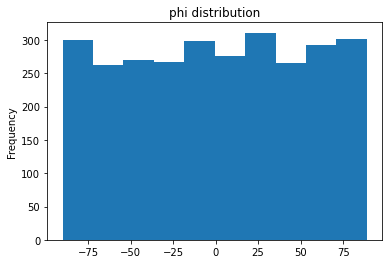

In [14]:
dataset360.phi.plot.hist(title = 'phi distribution')

<AxesSubplot:title={'center':'theta distribution'}, ylabel='Frequency'>

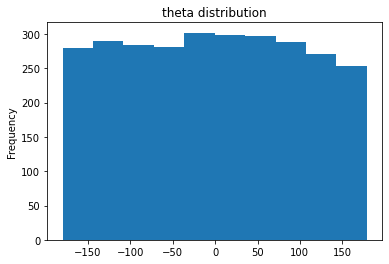

In [15]:
dataset360.theta.plot.hist(title = 'theta distribution')

<AxesSubplot:title={'center':'r_h distribution'}, ylabel='Frequency'>

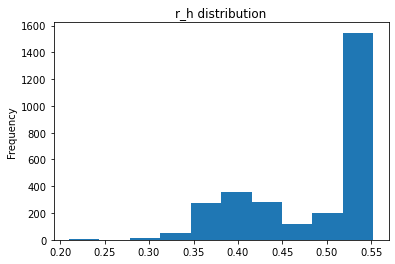

In [16]:
dataset360.r_h.plot.hist(title = 'r_h distribution')

<AxesSubplot:>

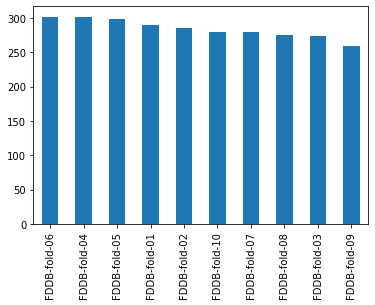

In [17]:
dataset360.fold.value_counts().plot.bar()

## Display Dataset

In [18]:
import matplotlib.pyplot as plt
from IPython.core.pylabtools import figsize
from equi_augmentation import *
figsize(5, 5)

In [19]:
dataset360 = pd.read_pickle('../dataframes/dataset360.pkl')

In [20]:
sample = dataset360.iloc[np.random.randint(dataset360.shape[0])]

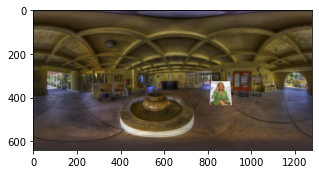

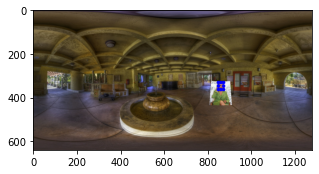

In [21]:
im = cv2.imread(sample.image_path)
plt.imshow(cv2.cvtColor(im, cv2.COLOR_BGR2RGB))
plt.show()
for face_points in sample.faces:
    im = draw_points(im, face_points, color = (255,0,0))
plt.imshow(cv2.cvtColor(im, cv2.COLOR_BGR2RGB))
plt.show()